In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imppot modules
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from PIL import Image

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_accuracy(outputs, masks, threshold=0.5):
    preds = torch.sigmoid(outputs)
    preds = (preds > threshold).float()
    correct = (preds == masks).float()
    return correct.sum() / correct.numel()

def calculate_dice(outputs, masks, threshold=0.5):
    preds = torch.sigmoid(outputs)
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum()
    dice = (2. * intersection) / (preds.sum() + masks.sum() + 1e-8)
    return dice

In [3]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.down1 = self.conv_block(3, 64)  # Renamed enc1 to down1
        self.down2 = self.conv_block(64, 128) # Renamed enc2 to down2
        self.down3 = self.conv_block(128, 256) # Renamed enc3 to down3
        self.down4 = self.conv_block(256, 512) # Renamed enc4 to down4

        self.middle = self.conv_block(512, 1024)  # Renamed center to middle

        self.up1 = self.conv_block(1024 + 512, 512) # Renamed dec4 to up1
        self.up2 = self.conv_block(512 + 256, 256) # Renamed dec3 to up2
        self.up3 = self.conv_block(256 + 128, 128) # Renamed dec2 to up3
        self.up4 = self.conv_block(128 + 64, 64) # Renamed dec1 to up4

        self.out = nn.Conv2d(64, n_classes, kernel_size=1) # Renamed final to out

        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Adjust the forward method to use the new layer names
        x1 = self.down1(x)
        x2 = self.down2(self.pool(x1))
        x3 = self.down3(self.pool(x2))
        x4 = self.down4(self.pool(x3))

        x5 = self.middle(self.pool(x4))

        x = self.up1(torch.cat([F.interpolate(x5, scale_factor=2, mode='bilinear', align_corners=True), x4], dim=1))
        x = self.up2(torch.cat([F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True), x3], dim=1))
        x = self.up3(torch.cat([F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True), x2], dim=1))
        x = self.up4(torch.cat([F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True), x1], dim=1))

        return self.out(x)

In [4]:
model_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/unet_greenery_segmentation.pth'
model = UNet(n_classes=1).to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=False)

model.eval()

print('✅ Model loaded successfully (with potential missing keys).')

✅ Model loaded successfully (with potential missing keys).


In [5]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class LabelmeTestDataset(Dataset):
    def __init__(self, root_dir, target_size=(512, 512)):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpg')]
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB').resize(self.target_size)

        # Find the corresponding Labelme JSON according to the image path
        json_path = image_path.replace('.jpg', '.json')
        with open(json_path, 'r') as f:
            label_data = json.load(f)

        # Generate mask
        mask = self.labelme_to_mask(label_data)

        # Convert to Tensor
        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # 增加一个通道

        return image, mask

    def labelme_to_mask(self, label_data):
        shapes = label_data['shapes']
        mask = np.zeros((label_data['imageHeight'], label_data['imageWidth']), dtype=np.uint8)

        for shape in shapes:
            points = shape['points']
            label = shape['label']

            (x1, y1), (x2, y2) = points
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)

            mask[y1:y2, x1:x2] = 1

        mask = Image.fromarray(mask).resize(self.target_size, resample=Image.NEAREST)
        mask = np.array(mask)

        return mask

In [6]:
test_dataset = LabelmeTestDataset(
    root_dir='/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/data/test_images_Diamond_bar',
    target_size=(512, 512)
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [7]:
def evaluate_model(model, test_loader):
    criterion = nn.BCEWithLogitsLoss()
    total_loss = 0.0
    total_accuracy = 0.0
    total_dice = 0.0
    num_batches = len(test_loader)

    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, desc='Evaluating', unit='batch') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)

                loss = criterion(outputs, masks)
                total_loss += loss.item()

                accuracy = calculate_accuracy(outputs, masks)
                dice = calculate_dice(outputs, masks)

                total_accuracy += accuracy.item()
                total_dice += dice.item()

                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), dice=dice.item())

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_dice = total_dice / num_batches

    print(f'\nTest Loss: {avg_loss:.4f}')
    print(f'Test Accuracy: {avg_accuracy:.4f}')
    print(f'Test Dice Score: {avg_dice:.4f}')

evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 9/9 [00:07<00:00,  1.17batch/s, accuracy=0.821, dice=0, loss=0.672]


Test Loss: 0.6743
Test Accuracy: 0.7861
Test Dice Score: 0.0000


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class PSPNetLite(nn.Module):
    def __init__(self, n_classes):
        super(PSPNetLite, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(512, 512, kernel_size=1)

        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)
        self.final = nn.Conv2d(512, n_classes, kernel_size=1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        pooled = self.pool(x)
        pooled = self.conv(pooled)
        pooled = F.interpolate(pooled, size=x.size()[2:], mode='bilinear', align_corners=True)
        x = x + pooled
        out = self.final(x)
        # Added upsampling to the final output
        out = self.upsample(out)
        return out

In [13]:
# Loading the model
psp_model_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/pspnet_greenery.pth'

model = PSPNetLite(n_classes=1).to(device)
state_dict = torch.load(psp_model_path, map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()

print('✅ PSPNet model loaded successfully (with potential missing keys).')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PSPNet model loaded successfully (with potential missing keys).


In [14]:
# Test with the same test_loader
evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 9/9 [00:01<00:00,  8.06batch/s, accuracy=0.2, dice=0.31, loss=0.736]


Test Loss: 0.7525
Test Accuracy: 0.2517
Test Dice Score: 0.3610


In [22]:
import matplotlib.pyplot as plt

def plot_model_comparison(unet_acc, unet_dice, pspnet_acc, pspnet_dice):
    models = ['UNet', 'PSPNet']
    accuracy = [unet_acc, pspnet_acc]
    dice = [unet_dice, pspnet_dice]

    x = range(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x, accuracy, width=width, label='Accuracy', color='skyblue')
    ax.bar([i + width for i in x], dice, width=width, label='Dice Score', color='lightgreen')

    ax.set_ylabel('Score')
    ax.set_title('Model Comparison on Test Set')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(models)
    ax.set_ylim(0, 1.0)
    ax.legend()
    plt.grid(axis='y')
    plt.show()

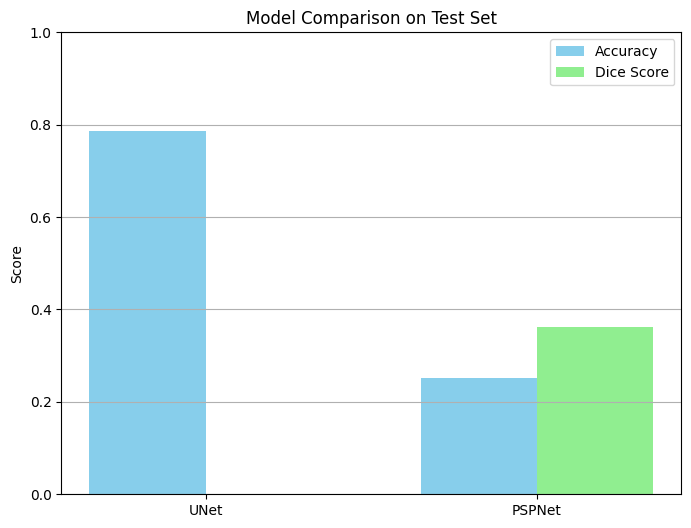

In [23]:
plot_model_comparison(unet_acc=0.7861, unet_dice=0.0, pspnet_acc=0.2517, pspnet_dice=0.3610)